In [3]:
#-----------------------------------
# GLOBAL FEATURE EXTRACTION
#-----------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py

#--------------------
# tunable-parameters
#--------------------
images_per_class = 80
fixed_size       = tuple((500, 500))
train_path       = "dataset/train"
h5_data          = 'output/data.h5'
h5_labels        = 'output/labels.h5'
bins             = 8

# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()


In [194]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['alfajor jorgito', 'flynn paff']


In [195]:
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        # get the image file name
        file = dir + "/" + str(x) + ".jpg"

        # read the image and resize it to a fixed-size
        try:
            image = cv2.imread(file)
            image = cv2.resize(image, fixed_size)
        except:
            print("Fallo la imagen: {}".format(file))
        else:
            ####################################
            # Global Feature extraction
            ####################################
            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image)

            ###################################
            # Concatenate global features
            ###################################
            global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

            # update the list of labels and feature vectors
            labels.append(current_label)
            global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

Fallo la imagen: dataset/train/alfajor jorgito/78.jpg
Fallo la imagen: dataset/train/alfajor jorgito/79.jpg
Fallo la imagen: dataset/train/alfajor jorgito/80.jpg
[STATUS] processed folder: alfajor jorgito
[STATUS] processed folder: flynn paff
[STATUS] completed Global Feature Extraction...


In [196]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

[STATUS] feature vector size (157, 532)
[STATUS] training Labels (157,)


In [197]:
# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

# scale features in the range (0-1)
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]
[STATUS] target labels shape: (157,)
[STATUS] end of training..


# Training

In [10]:
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.10
seed      = 9
train_path = "dataset/train"
test_path  = "dataset/test"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (157, 532)
[STATUS] labels shape: (157,)
[STATUS] training started...


/home/rodrigo/python-virtual-environments/changEat/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [199]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (141, 532)
Test data   : (16, 532)
Train labels: (141,)
Test labels : (16,)


LR: 0.864762 (0.093197)
LDA: 0.730000 (0.131623)
KNN: 0.800952 (0.138927)
CART: 0.830952 (0.129297)
RF: 0.900476 (0.091633)
NB: 0.744286 (0.144059)
SVM: 0.452857 (0.083312)


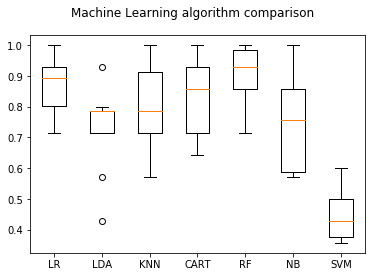

In [200]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

# Testing

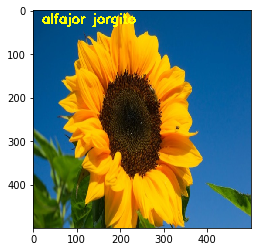

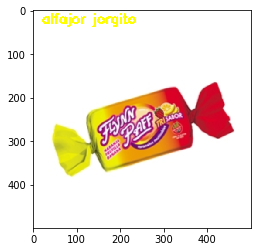

In [201]:
#-----------------------------------
# TESTING OUR MODEL
#-----------------------------------

# to visualize results
import matplotlib.pyplot as plt

for name, model in models:
    if name == 'RF':
        model_train = model
# create the model - Random Forests
#clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# loop through the test images
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)

    # resize the image
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # scale features in the range (0-1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaled_feature = scaler.fit_transform(global_feature.reshape(1,-1))

    # predict label of test image
    prediction = clf.predict(rescaled_feature.reshape(1,-1))[0]

    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

# Download google images

In [6]:
from google_images_download import google_images_download
#instantiate the class
response = google_images_download.googleimagesdownload()

In [12]:
from google_images_download import google_images_download
import shutil

download_path = "downloads"
limit = 80

def png_to_jpg(download_path):
    pngs = glob.glob(download_path + "*.png")
    for j in pngs:
        img = cv2.imread(j)
        cv2.imwrite(j[:-3] + 'jpg', img)
        os.remove(j)

def download_image(keywords, download_path, limit):
    
    for keyword in keywords:
        arguments = {"keywords":keyword,"limit":limit,"print_urls":False, format:"jpg"}
        print("STATUS: Downloading images for {}".format(keyword))
        paths = response.download(arguments)
        download_path_dest = download_path + "/" + keyword + "/"
        png_to_jpg(download_path_dest)
        # take all the images from the dataset
        image_paths = glob.glob(download_path_dest + "*.jpg")
        print("Cantidad descargas: {}".format(len(image_paths)))
        for index, image_path in enumerate(image_paths, start=1):
            original_path   = image_path
            image_path      = image_path.split("/")
            image_file_name = str(index) + ".jpg"
            os.rename(original_path, download_path_dest + image_file_name)
        dest_path = "dataset/train/" + keyword + "/"
        shutil.copytree(download_path_dest, dest_path)

In [13]:
keywords = ["flynn paff", "alfajor jorgito"]
keywords

['flynn paff', 'alfajor jorgito']

In [ ]:
download_image(keywords, download_path, limit)

STATUS: Downloading images for flynn paff

Item no.: 1 --> Item name = flynn paff
Evaluating...
Starting Download...
Completed Image ====> 1.Flynn_paff_1__62529.1565013167.jpg
Completed Image ====> 2.2182065_f.jpg
Completed Image ====> 3.2180741_f.jpg
Completed Image ====> 4.caramelos-flynn-paff-sin-tacc-x-20u-fiestissima-liniers-D_NQ_NP_916332-MLA32414838804_102019-Q.jpg
Completed Image ====> 5.flyn-aff-frutilla1-46cceefa6f9d89985315317058285551-640-0.png
Completed Image ====> 6.caramelos-masticables-flynn-paff-x70unid-cumpleanos-infantil-D_NQ_NP_292621-MLA20809870067_072016-F.jpg
Completed Image ====> 7.flynpaff11-e998b09421d3b14f2115537883879555-640-0.jpg


# New features

In [4]:
file = "dataset/train/flynn paff/4.jpg"
image = cv2.imread(file)
image = cv2.resize(image, fixed_size)

error: OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [4]:
fd_histogram(image).shape

(512,)

In [5]:
# Initiate STAR detector
orb = cv2.ORB()

In [ ]:
# find the keypoints with ORB
kp = orb.detect(image,None)

# compute the descriptors with ORB
kp, des = orb.compute(image, kp)